In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

import optuna
import xgboost as xgb

In [2]:
df = pd.read_csv("../data/cardiac_arrest_dataset.csv")
df.shape

(1025, 14)

# Data Preparation and Cleaning

In [3]:
def check_nulls_and_types(df):
    nulls_df = (df.isnull().sum()/ df.shape[0]*100).round(2).to_frame().rename(columns={0:'percentage_nulls'})
    types_df = df.dtypes.to_frame().rename(columns={0:'data_type'})
    rv = nulls_df.merge(types_df, left_index=True, right_index=True)
    return rv

In [4]:
check_nulls_and_types(df)

,percentage_nulls,data_type
age,0.0,int64
sex,0.0,int64
cp,0.0,int64
trestbps,0.0,int64
chol,0.0,int64
fbs,0.0,int64
restecg,0.0,int64
thalach,0.0,int64
exang,0.0,int64
oldpeak,0.0,float64


In [64]:
def identify_categorical_encoded_vars(df, maxcat=8):
    categorical = {}
    for c in df.columns:
        unique_values = df[c].unique()
        if (len(unique_values) < maxcat) & (c!='target'):
            categorical[c] = str(sorted(unique_values.tolist()))
    return categorical

In [65]:
categorical_vars = identify_categorical_encoded_vars(df)
categorical_vars

{'sex': '[0, 1]',
 'cp': '[0, 1, 2, 3]',
 'fbs': '[0, 1]',
 'restecg': '[0, 1, 2]',
 'exang': '[0, 1]',
 'slope': '[0, 1, 2]',
 'ca': '[0, 1, 2, 3, 4]',
 'thal': '[0, 1, 2, 3]'}

# Train/Val/Test Split 

In [66]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=40)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=40)
print(len(df_train), len(df_val), len(df_test))
# Keep train copy for charts
df_train_c = df_train.copy()

615 205 205


In [67]:
target = "target"

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

In [68]:
# Note from above table that all features are numerical
numerical_vars = df.select_dtypes(include='number').columns.to_list()
numerical_vars = [x for x in numerical_vars if x not in categorical_vars.keys()]
numerical_vars

['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']

In [69]:

def correlation_w_target(df, numerical_vars):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[numerical_vars].corr(), annot=True,  fmt='.2f')
    # Adding title and labels
    plt.title("Correlations", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.tight_layout() 
    plt.show()

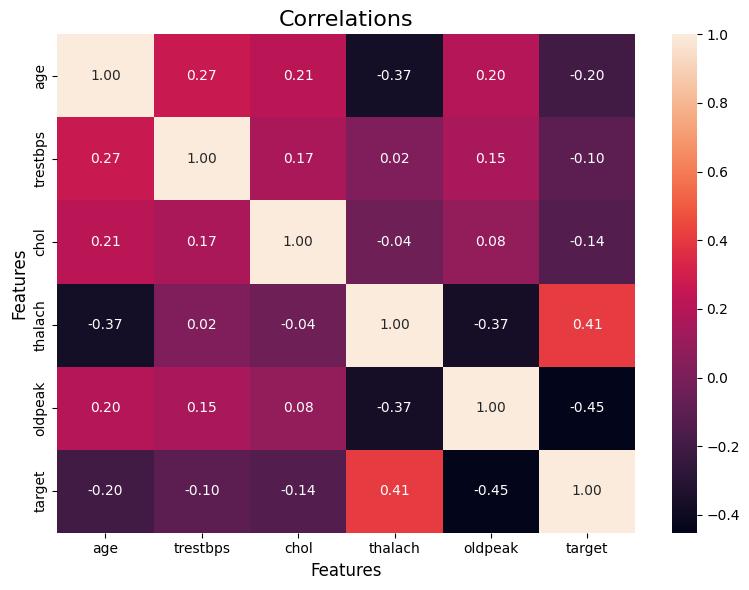

In [70]:
correlation_w_target(df_train_c, numerical_vars)

In [71]:
def identify_topk_correlated_features(df, numerical_vars, k):
    target = 'target'
    corr_matrix =  df[numerical_vars].corr()
    corr_matrix = corr_matrix[[target]].reset_index().rename(columns={"index":"features"})
    corr_matrix["abs_value"] = np.abs(corr_matrix[target])
    corr_matrix.query("features!=@target", inplace=True)
    return corr_matrix.sort_values("abs_value", ascending=False).head(k).reset_index(drop=True)


In [72]:
topk_numerical_features = identify_topk_correlated_features(df_train_c, numerical_vars, 5)
topk_numerical_features

,features,target,abs_value
0,oldpeak,-0.451785,0.451785
1,thalach,0.406757,0.406757
2,age,-0.198360,0.198360
3,chol,-0.135115,0.135115
4,trestbps,-0.101780,0.101780


# Top 5 Numerical Features

The correlation coefficients for the top 5 numerical features show:

- A strong negative corretion between the presence of heart disease (target) and

    - ST Depression (oldpeak) -> outcome of electrocardiogram

- A strong positive correlation with

    - thalach -> maximum heart rate

- A negative correlation with

    - Age

    - Cholesterol level

    - Resting Blood Pressure (trestbps)

In [73]:
locations =  [[0, 0], [0, 1], [1, 0], [1, 1]]
num_features = topk_numerical_features['features'][:-1]
plot_lst = list(zip(num_features, locations))

/var/folders/cx/qn3lmh6x4wl0s95g_jsflm540000gn/T/ipykernel_32300/3532192102.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df_train_c, x=col, hue="target", palette=sns.color_palette("Set2"), ax=axes[loc[0], loc[1]])
/var/folders/cx/qn3lmh6x4wl0s95g_jsflm540000gn/T/ipykernel_32300/3532192102.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df_train_c, x=col, hue="target", palette=sns.color_palette("Set2"), ax=axes[loc[0], loc[1]])
/var/folders/cx/qn3lmh6x4wl0s95g_jsflm540000gn/T/ipykernel_32300/3532192102.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df_train_c, x=col, hue="target", palette=sns.color_palette("Set2"), ax=axes[loc[0], loc[1]])
/var/folders/cx/qn3lmh6x4wl0s95g_jsflm540000gn/T/ipykernel_32300/3532192102.py:4: UserWarning: The palette list has more values (8) than

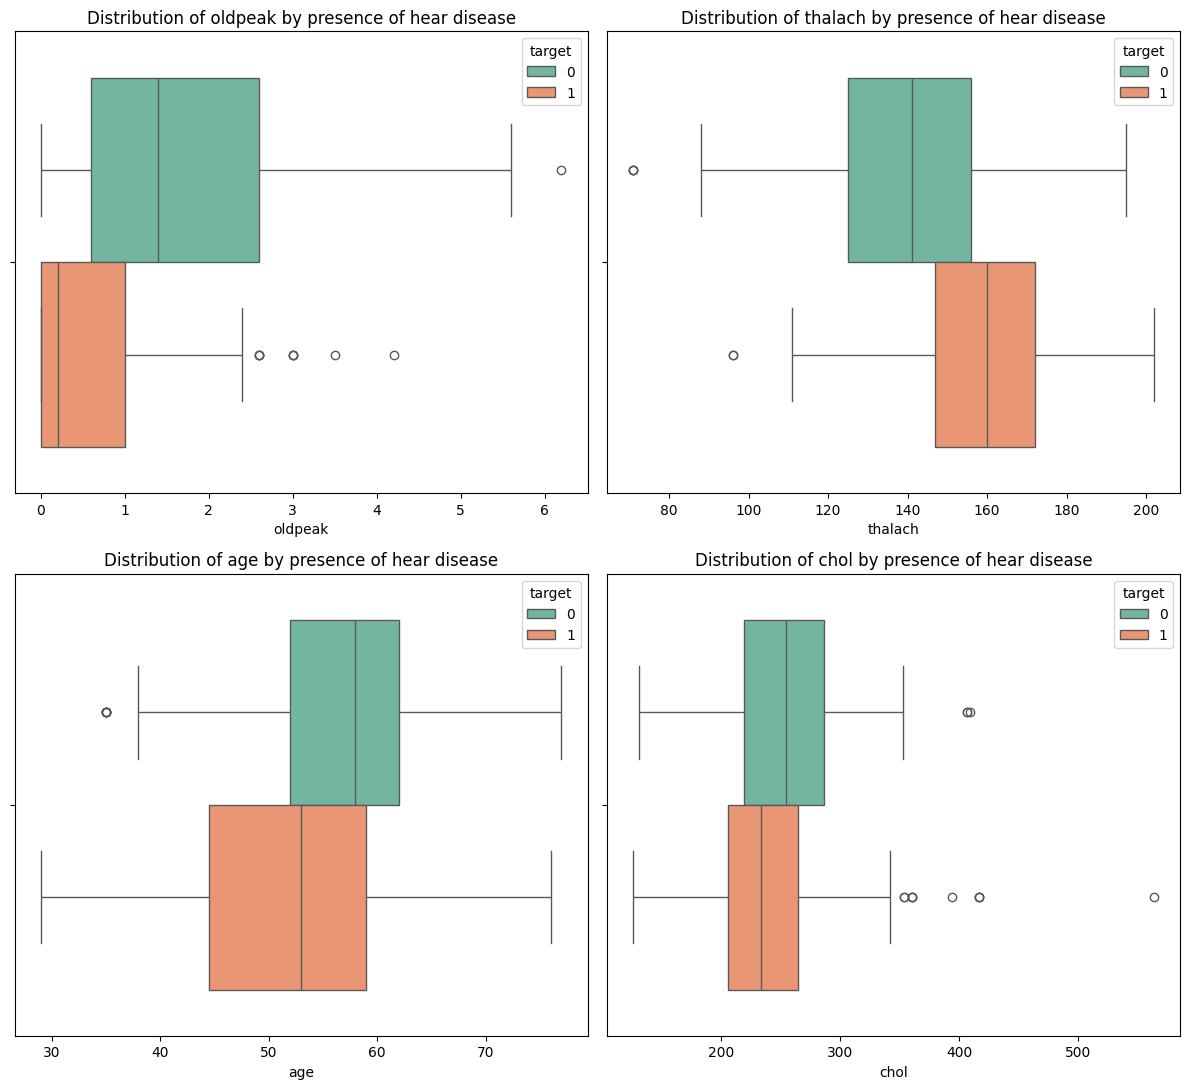

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11))

for col, loc in plot_lst:
    sns.boxplot(data=df_train_c, x=col, hue="target", palette=sns.color_palette("Set2"), ax=axes[loc[0], loc[1]])
    axes[loc[0], loc[1]].set_title(f"Distribution of {col} by Presence of Heart Disease")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Categorical Features

In [75]:
categorical_vars = list(categorical_vars.keys())

In [76]:
categorical_vars

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [116]:
mscores = {}
for c in categorical_vars:
    mscore = np.round(mutual_info_score(df_train_c[c], df_train_c['target']), 3)
    mscores[c] = mscore
mscore_df = pd.DataFrame(mscores.items(), columns=['feature', 'mutual_score'])
mscore_df.sort_values('mutual_score', ascending=False).head(3)

,feature,mutual_score
7,thal,0.150
1,cp,0.146
6,ca,0.139


In [119]:
def plot_crosstab(df, target, feature):
    target_name = "Presence of Heart Disease"
    crosstab = pd.crosstab(df[target], df[feature])
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
    plt.title(f"Relationship Between {target_name} and {feature.capitalize()}")
    plt.xlabel(f"{feature.capitalize()}")
    plt.ylabel(target_name)
    plt.show()

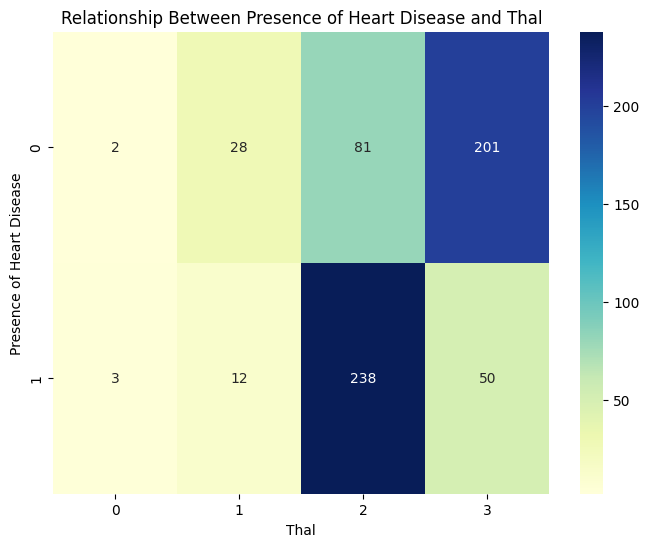

In [120]:
plot_crosstab(df_train_c, target='target', feature='thal')


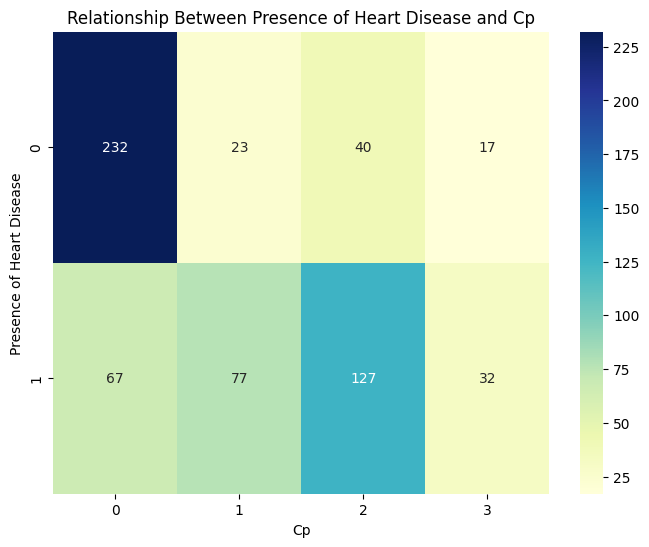

In [121]:
plot_crosstab(df_train_c, target='target', feature='cp')

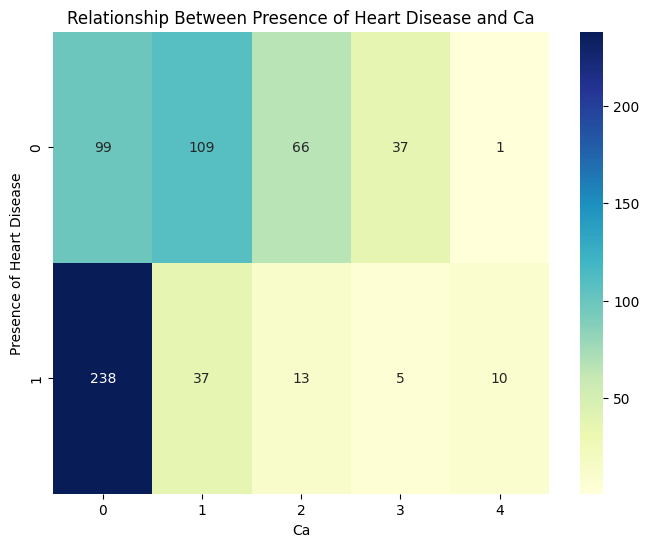

In [122]:
plot_crosstab(df_train_c, target='target', feature='ca')

# Summary Categorical Features

For the top 3 categorical features with the highest mutual information score we observe the following:

- It seems that most people without heart disease fall under category 3 for Thal, while the majority of those with heart disease have a category of 2.

- In the case of chest pain (cp), most of those without a heart disease reported a value of 0, while those with a heart disease have a more spred distribution with between 0-3.

- Lastly, for ca it seems that the vast majority of the people with a heart disease had a value of 0, while those without were more evenly spread across categories.



In [124]:
df_train_c['target'].value_counts()

target
0    312
1    303
Name: count, dtype: int64

# Training

In [126]:
for col in categorical_vars:
    df_train[col] = df_train[col].astype('category')
    df_val[col] = df_val[col].astype('category')

# Create DMatrix with categorical support
Xtrain = xgb.DMatrix(df_train, label=y_train, enable_categorical=True)
Xval = xgb.DMatrix(df_val, label=y_val, enable_categorical=True)

In [127]:

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc', 
    'tree_method': 'hist',
    'learning_rate': 0.1,
    'max_depth': 6
}
evals = [(Xtrain, 'train'), (Xval, 'val')]

model = xgb.train(
    params,
    Xtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,  # based on AUC by default
    verbose_eval=True
)

[0]	train-auc:0.98324	val-auc:0.69638
[1]	train-auc:0.98605	val-auc:0.69520
[2]	train-auc:0.98947	val-auc:0.69505
[3]	train-auc:0.99494	val-auc:0.73131
[4]	train-auc:0.99526	val-auc:0.72334
[5]	train-auc:0.99680	val-auc:0.74995
[6]	train-auc:0.99714	val-auc:0.76087
[7]	train-auc:0.99732	val-auc:0.77770
[8]	train-auc:0.99741	val-auc:0.78493
[9]	train-auc:0.99750	val-auc:0.78857
[10]	train-auc:0.99769	val-auc:0.79295
[11]	train-auc:0.99802	val-auc:0.79983
[12]	train-auc:0.99831	val-auc:0.80328
[13]	train-auc:0.99865	val-auc:0.80160
[14]	train-auc:0.99893	val-auc:0.82074
[15]	train-auc:0.99924	val-auc:0.83264
[16]	train-auc:0.99932	val-auc:0.84563
[17]	train-auc:0.99940	val-auc:0.85104
[18]	train-auc:0.99959	val-auc:0.84730
[19]	train-auc:0.99964	val-auc:0.85508
[20]	train-auc:0.99965	val-auc:0.85990
[21]	train-auc:0.99974	val-auc:0.86875
[22]	train-auc:0.99980	val-auc:0.87446
[23]	train-auc:0.99981	val-auc:0.87288
[24]	train-auc:0.99984	val-auc:0.87780
[25]	train-auc:0.99994	val-auc:0.87

# HyperParam Tuning

In [132]:
# Defining the objective function
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True)
    }
    

    model = xgb.train(
        param,
        Xtrain,
        num_boost_round=500,
        evals=[(Xval, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    preds = model.predict(Xval)
    auc = roc_auc_score(y_val, preds)
    return auc

In [133]:
# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2025-07-05 18:26:06,494] A new study created in memory with name: no-name-a1758bc6-63b3-4965-872a-0c1ba8ea1802


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-05 18:26:06,611] Trial 0 finished with value: 0.8861668634395907 and parameters: {'learning_rate': 0.05486134557501224, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5443776929462294, 'colsample_bytree': 0.78569730897711, 'lambda': 0.15719991427706068, 'alpha': 0.0017606656059916276}. Best is trial 0 with value: 0.8861668634395907.
[I 2025-07-05 18:26:06,747] Trial 1 finished with value: 0.9650728059818969 and parameters: {'learning_rate': 0.17209528261356946, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9047726887274035, 'colsample_bytree': 0.9658130098088755, 'lambda': 0.033375482069557316, 'alpha': 0.0056453047803404766}. Best is trial 1 with value: 0.9650728059818969.
[I 2025-07-05 18:26:07,012] Trial 2 finished with value: 0.9504132231404958 and parameters: {'learning_rate': 0.04603037047458094, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6826968973438816, 'colsample_bytree': 0.8758048444266622, 'lambda': 0.26584958060564684, 'alpha': 0.809628

In [136]:
# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)
print("Best AUC value:", study.best_value)

Best trial: FrozenTrial(number=21, state=1, values=[0.9723534041715861], datetime_start=datetime.datetime(2025, 7, 5, 18, 26, 9, 609961), datetime_complete=datetime.datetime(2025, 7, 5, 18, 26, 9, 818088), params={'learning_rate': 0.13711460986630852, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8793854472599835, 'colsample_bytree': 0.9510685345835943, 'lambda': 0.018642583828621564, 'alpha': 0.006446337320626534}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.001, st

In [147]:
model = xgb.train(dtrain=Xtrain, params=study.best_params)
preds_val = (model.predict(Xval) >= 0.5).astype(int)


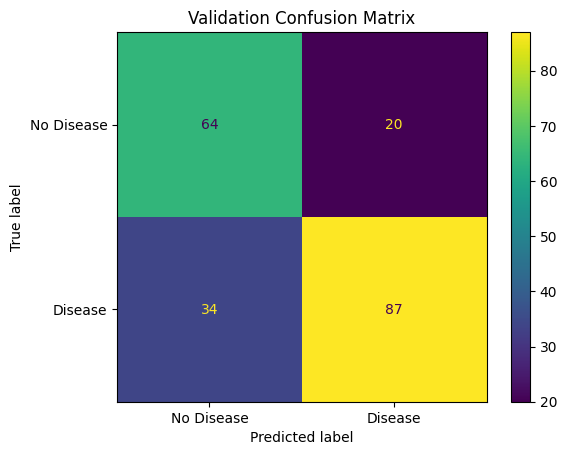

In [150]:
ConfusionMatrixDisplay.from_predictions(y_val, preds_val, display_labels=['No Disease', 'Disease'])
plt.title("Validation Confusion Matrix")
plt.show()


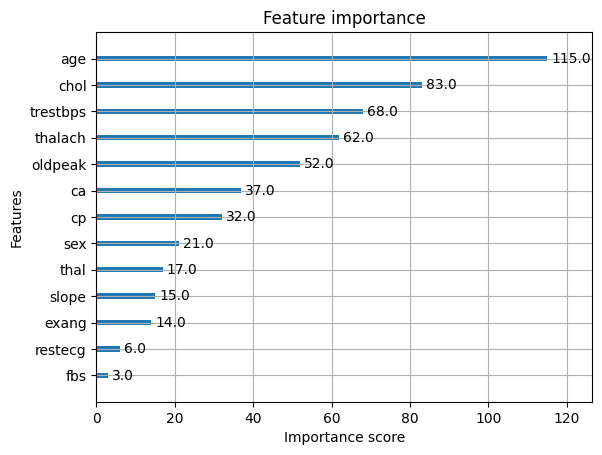

In [154]:
xgb.plot_importance(model)
plt.show()

In [155]:
target = "target"
y_full = df_full_train[target].values
del df_full_train[target]

for col in categorical_vars:
    df_full_train[col] = df_full_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

# Create DMatrix with categorical support
Xtrain_full = xgb.DMatrix(df_full_train, label=y_full, enable_categorical=True)
Xtest = xgb.DMatrix(df_test, label=y_test, enable_categorical=True)


model = xgb.train(dtrain=Xtrain_full, params=study.best_params)

y_pred_test = model.predict(Xtest)

In [159]:
roc_auc_score(y_test, y_pred_test)

1.0